In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '6' # Replace digit with number of desired GPU
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

%load_ext autoreload

In [2]:
# Basic Library Imports
import jax
import jax.numpy as jnp
from jax import random
from jax import vmap, jit, grad, value_and_grad

from flax import linen as nn
import optax

import matplotlib.pyplot as plt

import sys
from CausalAllenCahnModel import AllenCahnModel, SquareDataset
sys.path.append('..') # makes modules in parent repository available to import

In [3]:
%autoreload 2
from archs import arch_from_config, ActNet

In [4]:
# setup Allen-Cahn problem
import pickle

# load reference solution data
with open('ac_solution_dirichlet.pkl', 'rb') as file:
    gt_data = pickle.load(file)
usol = jnp.array(gt_data['usol']).astype(jnp.float32)

# Grid for reference solution
t_star = gt_data['t'].astype(jnp.float32)
x_star = gt_data['x'].astype(jnp.float32)
TT, XX = jnp.meshgrid(t_star, x_star)

# set up reference solution ins and outs
ins = (XX.flatten()[:,None], TT.flatten()[:,None])
outs = usol.flatten()[:,None]

/tmp/ipykernel_43403/1555955844.py:6: DeprecationWarning: Pickled array contains an aval with a named_shape attribute. This is deprecated and the code path supporting such avals will be removed. Please re-pickle the array.
  gt_data = pickle.load(file)


In [6]:
# setup other training configurations
num_steps_adam = 100_000
seed = 0
batch_size = 10_000
normalize_inputs = True
steps_per_check=500

# schedule of causal tolerances
causal_tols =  [1e-1, 1e0, 1e1, 1e2, 1e3, 1e3, 1e3, 1e4, 1e4, 1e4]

In [7]:
# split keys
keys = random.split(random.key(seed))

# build data loader
data_loader = SquareDataset(keys[0], batch_size=batch_size, minvals=(-1,0), maxvals=(1,1))
batch = next(iter(data_loader))

## ActNet

In [8]:
arch = ActNet(embed_dim=156, num_layers=4, num_freqs=4,
              out_dim=1,
              freeze_basis=False,
              w0_fixed=15,
              freq_scaling=True, freq_scaling_eps=1e-2,
              precision='highest')

# create optimizer
lr = optax.warmup_exponential_decay_schedule(
    1e-7, # init value
    5e-3, # peak value
    1_000, # wamup steps
    1_000, # transition_steps for decay
    0.9, # decay_rate
    end_value=5e-6, # stop decating once lr reaches this value
    )
optimizer = optax.chain(
    optax.adaptive_grad_clip(1e-2),
    optax.adam(learning_rate=lr),
    )

# create model
model = AllenCahnModel(
        arch, batch, optimizer=optimizer, key=keys[1], steps_per_check=steps_per_check,
        normalize_inputs=normalize_inputs, exact_bd_condition=True, bdr_enforcer_order=2,
        true_sol=(ins, outs))
print(model.tabulate())


                                       ActNet Summary                                       
┏━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ path       ┃ module   ┃ inputs             ┃ outputs            ┃ params                 ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│            │ ActNet   │ float32[10000,2]   │ float32[10000,1]   │                        │
├────────────┼──────────┼────────────────────┼────────────────────┼────────────────────────┤
│ Dense_0    │ Dense    │ float32[10000,2]   │ float32[10000,156] │ bias: float32[156]     │
│            │          │                    │                    │ kernel: float32[2,156] │
│            │          │                    │                    │                        │
│            │          │                    │                    │ 468 (1.9 KB)           │
├────────────┼──────────┼────────────────────┼────────────────────┼──

In [ ]:
for tol in causal_tols:
    print(f"Causal tolerance parameter is now {tol : .2e}.")
    model.train(data_loader, nIter=num_steps_adam // len(causal_tols), causal_eps=tol)

# compute final relative l2 error on the grid
pred = model.apply(model.params, ins[0], ins[1])
rel_l2_error = jnp.sqrt(((pred-outs)**2).sum() / ((outs)**2).sum())

print(f'Final loss is {model.loss_log[-1] : .2e} and relative L2 error is {rel_l2_error : .2e}')
model.plot_predictions((jnp.hstack(ins), outs))

Causal tolerance parameter is now  1.00e-01.


  0%|          | 0/10000 [00:00<?, ?it/s]

 47%|████▋     | 4704/10000 [02:09<02:19, 37.98it/s, loss: 1.141e-03, rel_l2: 2.68e-02, 'grad_norm': 2.55e-01]

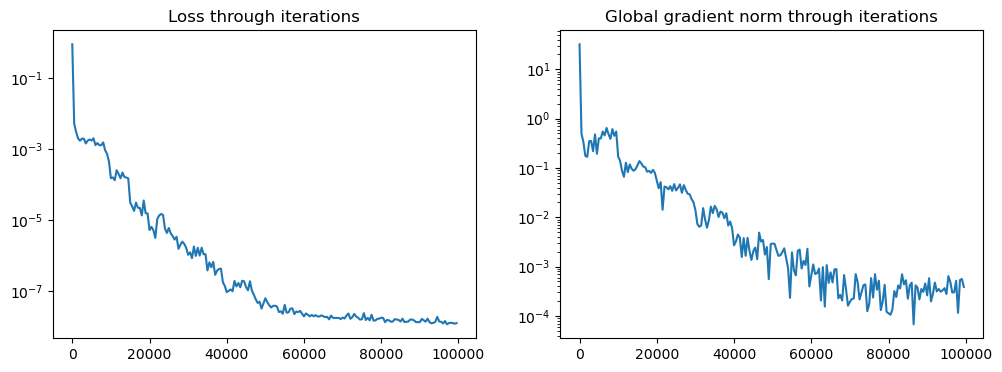

Relative L2 error: 4.51e-05
RMSE: 3.20e-05


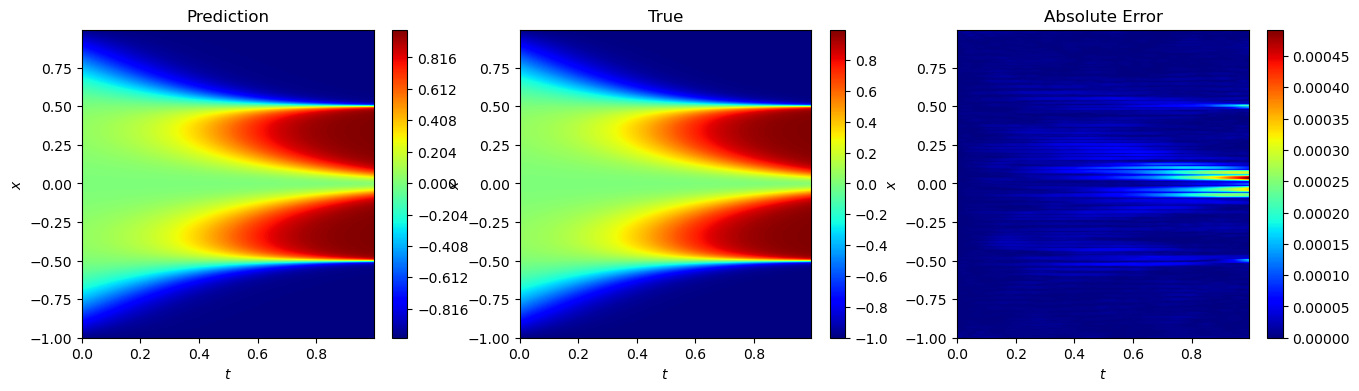

In [9]:
model.plot_logs()
model.plot_predictions((jnp.hstack(ins), outs))

Relative L2 error: 4.51e-05
RMSE: 3.20e-05


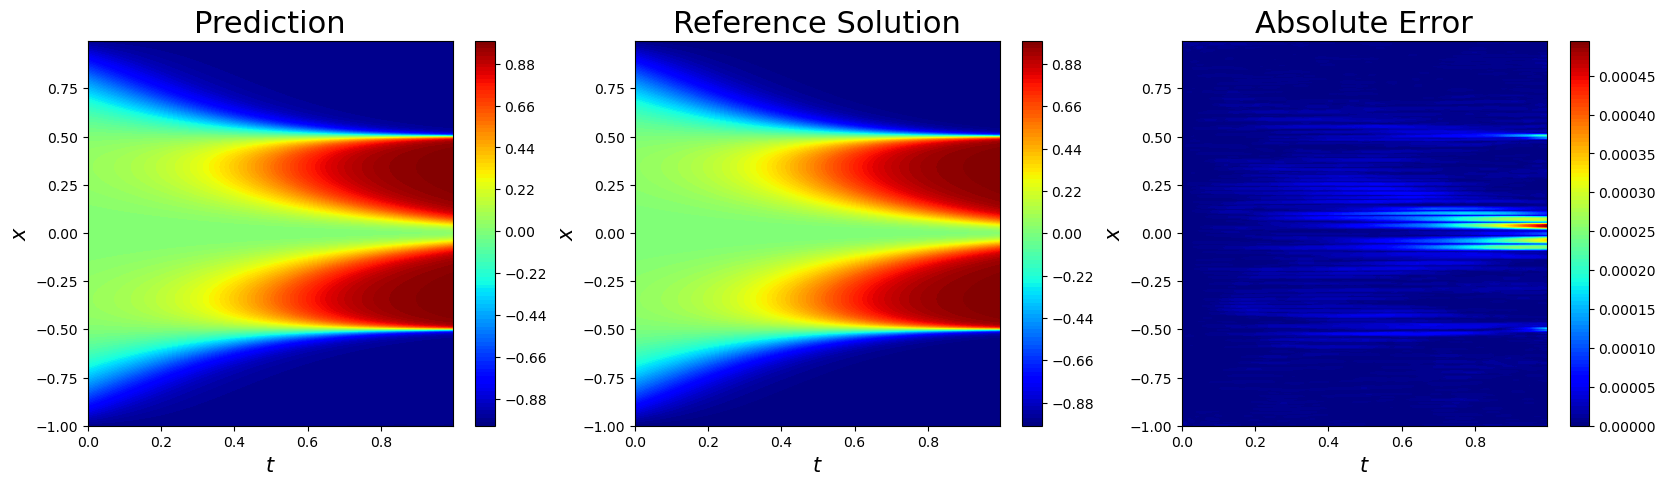

In [16]:
# Create predictions
u, s_true = jnp.hstack(ins), outs
s_pred = model.batched_apply(u, batch_size=2_048)
title_size=22
axis_size=15

error = s_pred - s_true
#print('Relative L2 error: {:.2e}'.format(jnp.linalg.norm(error, 2)/jnp.linalg.norm(s_true, 2)))
print('Relative L2 error: {:.2e}'.format(jnp.sqrt(jnp.sum(error**2)/jnp.sum(s_true**2))))
print('RMSE: {:.2e}'.format(jnp.sqrt(jnp.mean(error**2))))

plt.figure(figsize=(20, 5))

# Ploting examples of reconstructions
plt.subplot(131)
plt.tricontourf(u[:,1], u[:,0], s_pred.T.squeeze(), levels=100, cmap='jet')
plt.colorbar()
plt.xlabel('$t$', fontsize=axis_size)
plt.ylabel('$x$', fontsize=axis_size)
plt.title('Prediction', fontsize=title_size)

# Ploting true solution
plt.subplot(132)
plt.tricontourf(u[:,1], u[:,0], s_true.T.squeeze(), levels=100, cmap='jet')
plt.colorbar()
plt.xlabel('$t$', fontsize=axis_size)
plt.ylabel('$x$', fontsize=axis_size)
plt.title('Reference Solution', fontsize=title_size)

# Ploting absolute
plt.subplot(133)
plt.tricontourf(u[:,1], u[:,0], abs(s_pred-s_true).T.squeeze(), levels=100, cmap='jet')
plt.colorbar()
plt.xlabel('$t$', fontsize=axis_size)
plt.ylabel('$x$', fontsize=axis_size)
plt.title('Absolute Error', fontsize=title_size)


plt.savefig('ActNet_AllenCahn_prediction.png', bbox_inches='tight', dpi=300)
plt.show()

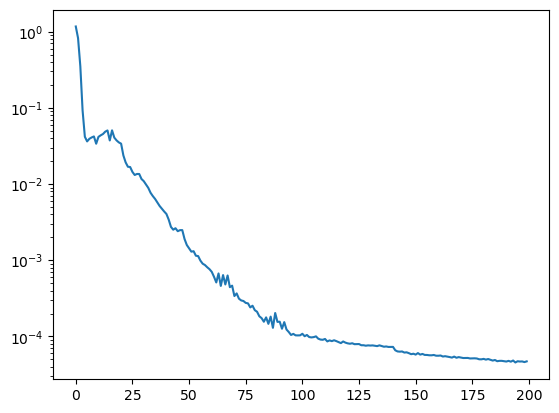

In [11]:
# checking relative L2 error curve through training
# would have probably gone down a bit more if continued training
plt.plot(model.rel_l2_log)
plt.yscale('log')
plt.show()